In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
import re
import pickle
import json
from scipy.spatial import KDTree
from easyric import caas_lite
import tifffile as tf
from skimage.transform import ProjectiveTransform
import random
from tqdm.notebook import tqdm

In [40]:
import seaborn as sns

In [3]:
import autosklearn
import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

In [4]:
with open('out/automl21.pickle', 'rb') as handle:
    automl21, X_train21, X_test21, y_train21, y_test21 = pickle.load(handle)

In [5]:
train_pred21 = automl21.predict(X_train21)
print("Train R2 score:", sklearn.metrics.r2_score(y_train21, train_pred21))
test_pred21 = automl21.predict(X_test21)
print("Test R2 score:", sklearn.metrics.r2_score(y_test21, test_pred21))

Train R2 score: 0.910664017367841
Test R2 score: 0.8142644656727074


In [6]:
with open('out/automl20.pickle', 'rb') as handle:
    automl20, X_train20, X_test20, y_train20, y_test20 = pickle.load(handle)

In [7]:
train_pred20 = automl20.predict(X_train20)
print("Train R2 score:", sklearn.metrics.r2_score(y_train20, train_pred20))
test_pred20 = automl20.predict(X_test20)
print("Test R2 score:", sklearn.metrics.r2_score(y_test20, test_pred20))

Train R2 score: 0.8167005542794976
Test R2 score: 0.7641199875933078


# draw figures

In [52]:
USMALL_SIZE = 12+ 8
SMALL_SIZE = 16 + 8
MEDIUM_SIZE = 18+ 8
BIGGER_SIZE = 20 + 8

cm = 1/2.54

#plt.rc('font', size=SMALL_SIZE, family='Times New Roman')          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [78]:
palette = sns.color_palette("crest", n_colors=10)
palette

[(0.54664626, 0.75500662, 0.56925799),
 (0.44705356, 0.70778212, 0.56642189),
 (0.36191986, 0.65736125, 0.56541032),
 (0.2905079, 0.60215628, 0.56242036),
 (0.23160473, 0.54861143, 0.5567573),
 (0.17310341, 0.49542924, 0.5504176),
 (0.12382162, 0.44120373, 0.54372156),
 (0.11273683, 0.38131546, 0.53162393),
 (0.13389954, 0.32070138, 0.51111946),
 (0.15954301, 0.25770084, 0.47845341)]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

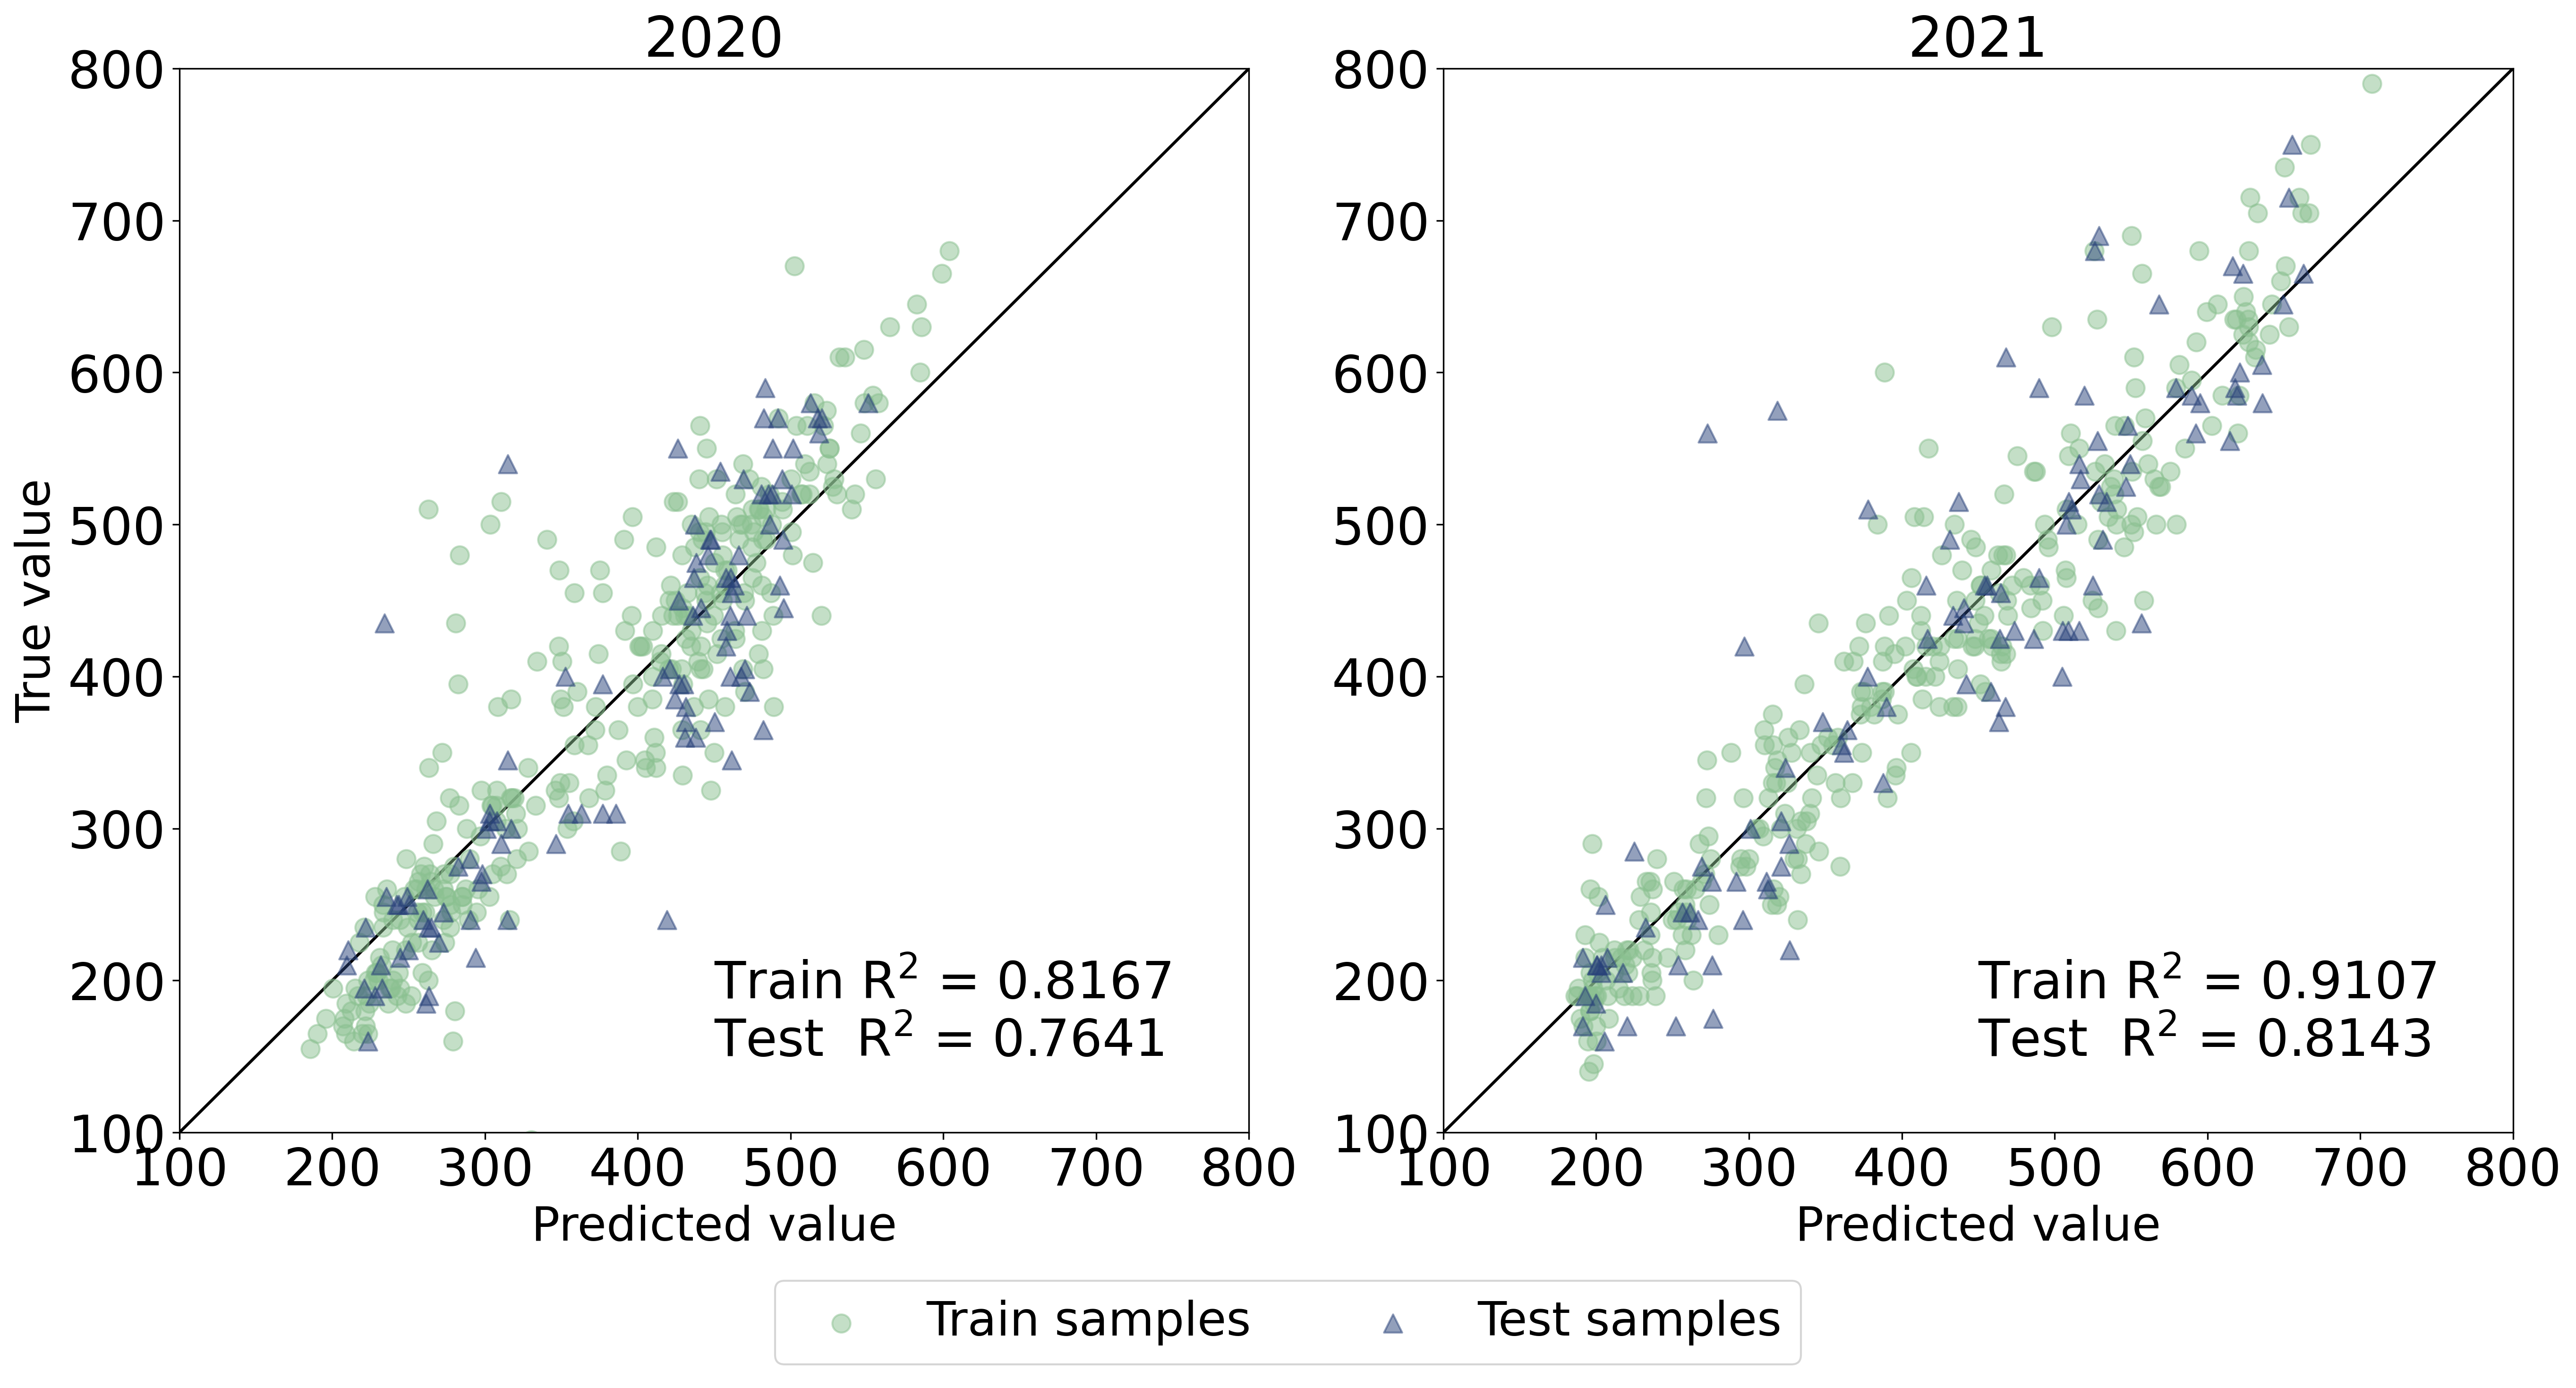

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(18.46, 10), dpi=300)

ax[0].scatter(train_pred20, y_train20, label="Train samples", c=palette[0], marker='o', alpha=0.5, s=85)
ax[0].scatter(test_pred20, y_test20, label="Test samples", c=palette[-1], marker='^', alpha=0.5, s=85)
ax[0].set_xlabel("Predicted value")
ax[0].set_ylabel("True value")
ax[0].set_title("2020")
ax[0].set_xlim([100, 800])
ax[0].set_ylim([100, 800])
ax[0].set_xticks(np.linspace(100, 800, 8))
ax[0].plot([30, 800], [30, 800], c='k', zorder=0)
ax[0].text(450, 150, f"Train R$^2$ = {round(sklearn.metrics.r2_score(y_train20, train_pred20), 4)}\nTest  R$^2$ = {round(sklearn.metrics.r2_score(y_test20, test_pred20), 4)}", fontsize=26)

ax[1].scatter(train_pred21, y_train21, c=palette[0], marker='o', alpha=0.5, s=85)
ax[1].scatter(test_pred21, y_test21, c=palette[-1],  marker='^', alpha=0.5, s=85)
ax[1].set_xlabel("Predicted value")
ax[1].set_xlim([100, 800])
ax[1].set_ylim([100, 800])
ax[1].set_xticks(np.linspace(100, 800, 8))
ax[1].set_title("2021")
ax[1].text(450, 150, f"Train R$^2$ = {round(sklearn.metrics.r2_score(y_train21, train_pred21), 4)}\nTest  R$^2$ = {round(sklearn.metrics.r2_score(y_test21, test_pred21), 4)}", fontsize=26)
ax[1].plot([30, 800], [30, 800], c='k', zorder=0)

fig.legend(loc="lower center", ncol=2)
plt.tight_layout(rect=[0, 0.08, 1,1])
plt.savefig("figures/automl_train.png")
plt.show()

In [38]:
uav_measured20 = pd.read_excel("out/2020_measured_weight.xlsx")
uav_measured21 = pd.read_excel("out/2021_measured_weight.xlsx")

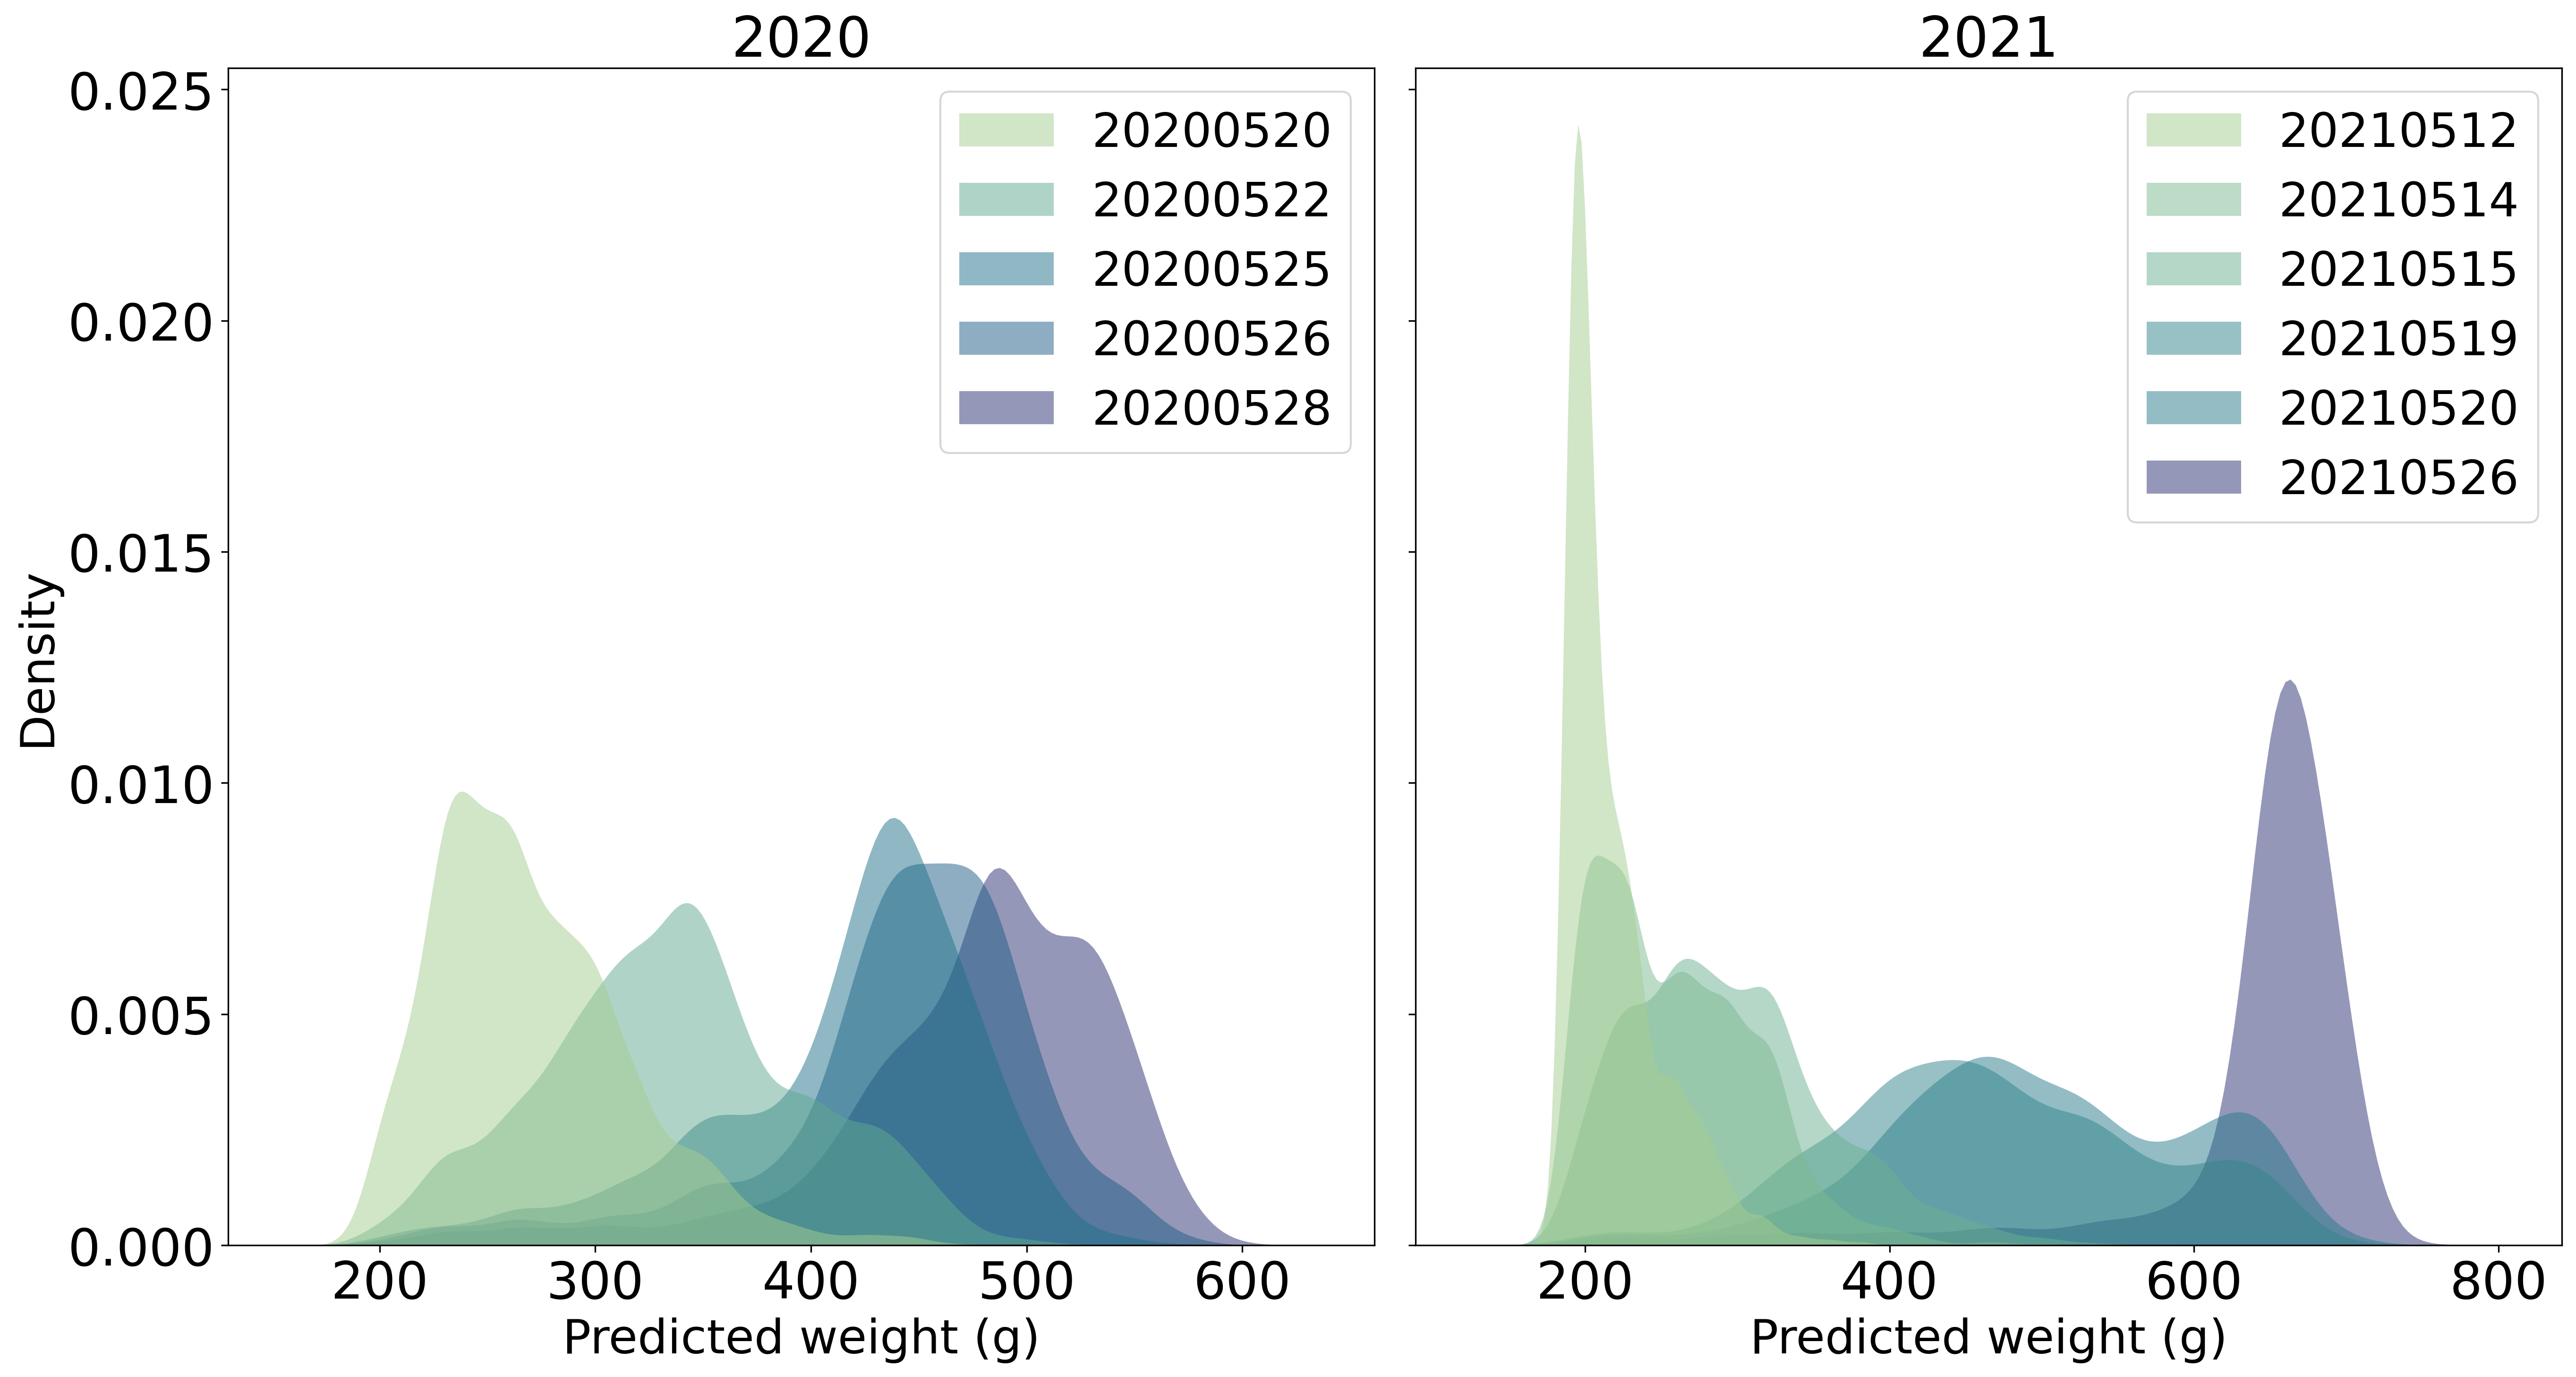

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(18.46, 10), dpi=300, sharey=True)

sns.kdeplot(
   data=uav_measured20, x="weight_pred", hue="date",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0, ax=ax[0]
)

ax[0].set_xlabel("Predicted weight (g)")
ax[0].get_legend().set_title(None)
#ax[0].legend(labels=["May 20", "May 22", "May 25", "May 26", "May 28"])
ax[0].set_title("2020")

sns.kdeplot(
   data=uav_measured21, x="weight_pred", hue="date",
   fill=True, common_norm=False, palette="crest",
   alpha=.5, linewidth=0, ax=ax[1]
)

ax[1].set_xlabel("Predicted weight (g)")
ax[1].get_legend().set_title(None)
#ax[1].legend(labels=["May 12", "May 14", "May 15", "May 19", "May 20", "May 26"])
ax[1].set_title("2021")

plt.tight_layout()
plt.savefig("figures/automl_pred.png")
plt.show()

In [68]:
label_list = []
for t in ax[0].get_legend_handles_labels():
    # the first result will be all handles, i.e. the dots in the legend
    # the second result will be all legend text
    label_list.append(t)

In [69]:
label_list

[[], []]